# **Title: Sentiment Analysis on how Ukraine is perceived on the international scene during the Russian invasion of Ukraine**

## Problem Statement and Introduction:

The Russian invasion of Ukraine has been a widely discussed topic on the international scene. The way in which the conflict is perceived by the public can have a significant impact on foreign policy decisions and public opinion towards the involved countries. Therefore, sentiment analysis of news, tweets, and articles about the Ukrainian war can provide valuable insights into the attitudes and opinions of people towards this conflict. The aim of this project is to conduct sentiment analysis on a labeled dataset of text and gather our own cleaned dataset, train at least four classification algorithms, and compare the results obtained from a pre-trained model. Additionally, the project aims to determine the factors that influenced the sentiment derived from the analysis by using existing NLP models and visualizing the findings through techniques such as word clouds.

In [234]:
# Import required libraries
! pip install langdetect 
import pandas as pd
import numpy as np
import nltk
import collections
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from langdetect import detect_langs
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from wordcloud import ImageColorGenerator
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import datetime
import math
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel
!pip install pyLDAvis
import pyLDAvis.gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.8 MB/s eta 0:00:00


# **Sentiment Modeling**

In [ ]:
# Reading the given data into dataframe
df = pd.read_csv("sentiment_analysis.csv") 
df.head(3)

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1


In [ ]:
print(df["label"].value_counts(normalize=True),'\n')
print(df.info())

1    0.674686
0    0.325314
Name: label, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550391 entries, 0 to 550390
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      550391 non-null  float64
 1   text    550391 non-null  object 
 2   label   550391 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.6+ MB
None


The data_frame contains 550391 rows and 3 columns, without non values. The text column contains the tweet content and  The label column has the opinion : positive 1, negative 0. 67.46%  positive opinion, 32% negative.

In [ ]:
DF = df.copy(deep=True)
DF=DF.rename(columns={'text':'Text'})

In [ ]:
# Defining a function which does all required text preprocessing on a given dataframe
def text_preprocessing(df):
  ''' Input DataFrame is required to have a column named "Text" 
      on which all pre-processing will be done'''

  DF=df.copy(deep=True)


  # Changing to lowercase 
  DF['Text'] = DF['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing special characters and words following @
  special_char=["rt","@\w*","http\S*","t.co\S*","[^a-zA-Z\s]","[^\w\s]"]
  for i in special_char:
    DF['Text'] = DF['Text'].str.replace(i,'')

  def language(sen):
    sen_t=sen.replace(' ','')
    if len(sen_t)>5:
      lang=detect_langs(sen)[0].lang
    else:
      lang='noten'
    return lang
  
  # Keeping examples only in English Language
  if ('Language' in (DF.columns)):
    idx=DF['Language']=='en'
    DF=DF[idx]  
  else:
    lang=DF['Text'].apply(lambda x:language(x))
    idx=lang=='en'
    DF=DF[idx]


  # Removing rows which have no non-whitespace characters   
  DF_T=DF.copy(deep=True)
  DF_T['Text'] = DF_T['Text'].str.replace(' ','')
  idx=(DF_T['Text'].apply(lambda x:len(x)))>0
  DF=DF[idx]

  # Removing stopwords
  stop_words = stopwords.words('english')
  DF['Text'] = DF['Text'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))


  # Removing rare words
  words= pd.Series(' '.join(DF['Text']).split()).value_counts()
  idx=words==1
  rare_words=words[idx]
  DF['Text'] = DF['Text'].apply(lambda x: ' '.join(x for x in x.split() if x not in rare_words))

  # Performing Tokenization
  DF['Text'] = DF['Text'].apply(lambda x: word_tokenize(x))

  stemmer = PorterStemmer()
  def stemming(L):
    for i in range(0,len(L)):
     L[i]=stemmer.stem(L[i])
    return L

  # Performing Stemming
  DF['Text'] = DF['Text'].apply(lambda x: stemming(x))

  return DF

In [ ]:
'''  Below Commented Lines of codes are used to process raw data using 
above function - 'text_preprocessing'. 
Since, we have already run the processing, and saved the file, now we can just
upload the file and use it directly.
The processed file name is 'sentiment_analysis_pre-processed.csv' 
'''
#Processed_DF=text_preprocessing(DF)    
#Processed_DF=Processed_DF[['Text','label']]
#Processed_DF.to_csv('sentiment_analysis_pre-processed.csv', sep=',', index=False)
df = pd.read_csv("sentiment_analysis_pre-processed.csv") 
df

,Text,label
0,"['josh', 'jenkin', 'look', 'forward', 'tab', '...",1
1,"['congratul', 'pakistan', 'becom', 'notestteam...",1
2,"['septemb', 'take', 'main', 'surpris', 'thanks...",1
3,"['newli', 'paint', 'wall', 'thank', 'million',...",1
4,"['excit', 'announc', 'juli', 'lab', 'reloc']",1
...,...,...
504691,"['cant', 'stop', 'watch']",0
504692,"['poor', 'old', 'tom', 'odel', 'doesnt', 'look...",0
504693,"['antsmash', 'smash', 'ant', 'awesom']",1
504694,"['morn', 'girl', 'wonder', 'friday']",1


Because of computational limitations, we will be dividing the above pre-processed dataframe into four subsets and train four classification models on these four subsets separately

In [ ]:
# First, shuffling the above dataframe
df=pd.DataFrame(np.random.permutation(df),columns=df.columns)
y=df['label']
y=y.astype(float)
# Making four dataframes out of one pre-processed dataframe
df_1=df.iloc[0:126000,:]
y1=y[0:126000]

df_2=df.iloc[126000:252000,:]
y2=y[126000:252000]

df_3=df.iloc[252000:378000,:]
y3=y[252000:378000]

df_4=df.iloc[378000:504690,:]
y4=y[378000:504690]

In [ ]:
# We will fit the TFIDF vectorizer on the complete dataframe
# But transformation will be done on the subset dataframes
# This will help maintain genralization of features across the four models
vectorizer = TfidfVectorizer(analyzer='word',token_pattern=r'\b[a-zA-Z]{3,}\b', min_df=100)
vectorizer.fit(df['Text'])

TfidfVectorizer(min_df=100, token_pattern='\\b[a-zA-Z]{3,}\\b')

**1) Multinomial NAIVE BAYES**

In [ ]:
X=vectorizer.transform(df_1['Text']) # Using First Subset for Naive Bayes
X=X.toarray()
X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names_out())
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y1, test_size=0.20, random_state=10)

In [ ]:
# Multinomial Naive Bayes
parameters = {'alpha':[0.01,0.05,0.1,0.5,1,5,10]}
model_NB= MultinomialNB()
clf = GridSearchCV(model_NB, parameters, cv=5, n_jobs=2)
#clf.fit(X_Train, y_Train)          ### No need to run again
best_score=92.26
best_param="'alpha':1"
print(f'The best cross-validation score: {round(best_score,2)}%')
print(f'The best parameter: '+best_param)

The best cross-validation score: 92.26%
The best parameter: 'alpha':1


In [ ]:
bestmodel_NB=MultinomialNB(alpha=1.0)
bestmodel_NB.fit(X_Train, y_Train)
predictNB = bestmodel_NB.predict(X_Test)

test_accuracy = accuracy_score(y_Test, predictNB)
test_f1 = f1_score(y_Test, predictNB)

print(f'Test accuracy of Multinomial Naive Bayes model: {round(test_accuracy*100,2)}%')
print(f'Test f1 of Multinomial Naive Bayes model: {round(test_f1,2)}')

Test accuracy of Multinomial Naive Bayes model: 92.49%
Test f1 of Multinomial Naive Bayes model: 0.95


**2) Logistic Regression**

In [ ]:
X=vectorizer.transform(df_2['Text']) # Using Second Subset for Logistic Regression
X=X.toarray()
X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names_out())
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y2, test_size=0.20, random_state=10)

In [ ]:
parameters = {'C':[0.001,0.01, 0.1, 1, 5,20 ], 'penalty':['l1','l2']}

model_LR= LogisticRegression (solver='liblinear',max_iter=1000)
clf = GridSearchCV(model_LR, parameters, cv=5, n_jobs=2)
#clf.fit(X_Train, y_Train)     ### No need to run again
best_score=95.63
best_param="'C':5, 'penalty':'l2'"

print(f'The best cross-validation score: {round(best_score,2)}%')
print(f'The best parameter: '+best_param)

The best cross-validation score: 95.63%
The best parameter: 'C':5, 'penalty':'l2'


In [ ]:
bestmodel_LR=LogisticRegression(max_iter=1000,C=5, solver= 'liblinear',penalty='l2')
bestmodel_LR.fit(X_Train, y_Train)
predictLR = bestmodel_LR.predict(X_Test)

test_accuracy = accuracy_score(y_Test, predictLR)
test_f1 = f1_score(y_Test, predictLR)

print(f'Test accuracy of Logestic Regression model: {round(test_accuracy*100,2)}%')
print(f'Test f1 score of Logestic Regression model: {round(test_f1,2)}')

Test accuracy of Logestic Regression model: 96.03%
Test f1 score of Logestic Regression model: 0.97


**3) Linear Support Vector Machine**

In [ ]:
X=vectorizer.transform(df_3['Text']) # Using Third Subset for SVM
X=X.toarray()
X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names_out())
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y3, test_size=0.20, random_state=10)

In [ ]:
parameters = {'C':[0.001, 0.01, 0.1, 1,5,10],'penalty':['l1','l2']}

model_SVC = LinearSVC(random_state=0, tol=1e-5,loss='squared_hinge',dual=False)
clf = GridSearchCV(model_SVC, parameters, cv=5, n_jobs=2)
#clf.fit(X_Train, y_Train)    ### No need to run again
best_score=95.66
best_param="'C':0.1, 'penalty':'l2'"

print(f'The best cross-validation score: {round(best_score,2)}%')
print(f'The best parameter: '+best_param)

The best cross-validation score: 95.66%
The best parameter: 'C':0.1, 'penalty':'l2'


In [ ]:
bestmodel_SVC=LinearSVC(random_state=0, tol=1e-5,loss='squared_hinge',C = 0.1,penalty='l2',dual=False)
bestmodel_SVC.fit(X_Train, y_Train)
predictSVC = bestmodel_SVC.predict(X_Test)

test_accuracy = accuracy_score(y_Test, predictSVC)
test_f1 = f1_score(y_Test, predictSVC)

print(f'Test accuracy of SVC model: {round(test_accuracy*100,2)}%')
print(f'Test f1 score of SVC model: {round(test_f1,2)}')

Test accuracy of SVC model: 95.81%
Test f1 score of SVC model: 0.97


**4) Random Forest**

In [ ]:
X=vectorizer.transform(df_4['Text']) # Using Fourth Subset for Random Forest
X=X.toarray()
X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names_out())
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y4, test_size=0.20, random_state=10)

In [ ]:
parameters = {'n_estimators': [10,15,20],
              'min_samples_split': [100,200],
              'max_depth': [100,150]} 

model_RF = RandomForestClassifier(random_state=10)
clf = GridSearchCV(model_RF, parameters, cv=5, n_jobs=4)
#clf.fit(X_Train, y_Train)          ### No need to run again
best_score=92.94
best_param="'max_depth': 150, 'min_samples_split': 100, 'n_estimators': 20"

print(f'The best cross-validation score: {round(best_score,2)}%')
print(f'The best parameter: '+best_param)

The best cross-validation score: 92.94%
The best parameter: 'max_depth': 150, 'min_samples_split': 100, 'n_estimators': 20


In [ ]:
bestmodel_RF = RandomForestClassifier(random_state=0, max_depth=150, n_estimators=20,min_samples_split=100)
bestmodel_RF.fit(X_Train, y_Train)
predictRF = bestmodel_RF.predict(X_Test)

test_accuracy = accuracy_score(y_Test, predictRF)
test_f1 = f1_score(y_Test, predictRF)

print(f'Test accuracy of RF model: {round(test_accuracy*100,2)}%')
print(f'Test f1 of RF model: {round(test_f1,2)}')

Test accuracy of RF model: 92.94%
Test f1 of RF model: 0.95


In [ ]:
predictRF_train=bestmodel_RF.predict(X_Train)
accuracy_score(y_Train, predictRF_train)

0.9570704080827216

Next, we will prepare an ensemble from three of the above four models. Since, it is always better to have models in ensemble which are diverse in terms of algorithms. Therefore, we will have following three models in our ensemble,     
1) Naive Bayes     
2) Logistic Regression       
3) Random Forest      

In [125]:
# Preparing ensemble of three sentiment classifiers
CL_1 = MultinomialNB(alpha=1.0)
CL_2 = LogisticRegression(max_iter=1000,C=5, solver= 'liblinear',penalty='l2')
CL_4 = RandomForestClassifier(random_state=0, max_depth=150, n_estimators=20,min_samples_split=100)

est = [('Naive Bayes', CL_1), ('Logistic Regression', CL_2), ('Random Forest', CL_4)]
ens_sent_clf = VotingClassifier(estimators=est, voting='hard',n_jobs=1)

Now just for reference,
We will train our ensemble model using half of the entire pre-processed dataframe instead of the subsets, and check the test set accuracy

In [ ]:
df=pd.DataFrame(np.random.permutation(df),columns=df.columns)
h=int(df.shape[0]*0.5)
df_h=df.iloc[0:h,:]
y=df_h['label']
y=y.astype(float)

# Making Training Set and Test Set for use with ensemble model
X=vectorizer.transform(df_h['Text'])
X=X.toarray()
X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names_out())

# Making Training and Test set manually because of RAM limitation
t=int((X.shape[0])*0.8)
X_Train=X.iloc[0:t,:]
y_Train=y[0:t]
X_Test=X.iloc[t:,:]
y_Test=y[t:]

In [ ]:
''' Not Running the below fit again, instead hard coding the results'''
#ens_sent_clf.fit(X_Train, y_Train)
#predict_ens = ens_sent_clf.predict(X_Test)
#test_accuracy = accuracy_score(y_Test, predict_ens)
#test_f1 = f1_score(y_Test, predict_ens)
test_accuracy=0.9569
test_f1=0.97

print(f'Test accuracy of Ensemble Model: {round(test_accuracy*100,2)}%')
print(f'Test f1 of Ensemble Model: {round(test_f1,2)}')

Test accuracy of Ensemble Model: 95.69%
Test f1 of Ensemble Model: 0.97


It is to be noted that the dataset used for training the above ensemble model does not have examples related to the context of the application, which is Russia-Ukraine Conflict.    
It is therefore of utmost importance to include enough examples in training data related to the application of the model. 

**Our strategy for model training is proposed as below:**

1. Only include 80K examples from the labelled dataset : 'sentiment\_analysis', with 40K examples of positive sentiment tweets, and 40K examples of negative sentiment tweets, to give a general idea of positive and negative sentiment examples to the model.
    
2. We will generate another training dataset from twitter datasets related to Russia-Ukraine War. Since, these datasets will not be labelled in their raw form, we will label them using below strategy:  
    (i) Label the tweets containing the words 'kill,crime,war, violence, invasion, attack,conflict,evil,weapon,missile,lies, fight,shelling,genocide,death' to be negative sentiment tweets.It is interesting to note that, major proportion of these negative sentiment tweets can be regarded as Pro-Ukrainian Tweets. For this purpose, we will use #StandwithUkraine twitter dataset from Kaggle.
    

(ii) To build a well trained classifier with respect to the task at hand, we need examles of positive sentiment tweets. For this, we shall combine examples with #standwithrussia #istandwithrussia #standwithputin #istandwithputin #stopnato For this purpose, we use 'The Russian invasion of Ukraine without retweets' dataset from Kaggle. We will filter the tweets with above hashtags from this dataset

**Preparing Training Data**

In [126]:
# Part 1 from proposal above
# From given dataset for Part 1, 'sentiment_analysis.csv'
# Taking 40K examples for positive sentiment , i.e. with label 1
# Taking 40K examples for negative sentiment, i.e. with label 0
df = pd.read_csv("sentiment_analysis.csv") 
df=pd.DataFrame(np.random.permutation(df),columns=df.columns)
idx=df['label']==1
df_1=(df[idx]).iloc[0:40000]
idx=df['label']==0
df_2=(df[idx]).iloc[0:40000]
df_tr1=pd.concat([df_1,df_2])
df_tr1=pd.DataFrame(np.random.permutation(df_tr1),columns=df.columns)
df_tr1=df_tr1.rename(columns={'text': 'Text'})
df_tr1=df_tr1.reset_index()
df_tr1=df_tr1[['Text','label']]

In [127]:
# Defining function which removes the words that are expected to be in majority of the hashtags
# because this might mislead the model
def remove_gen_keywords(df):
  df['Text'] = df['Text'].str.replace('StandWithUkraine','')  
  df['Text'] = df['Text'].str.replace('standwithukraine','')  
  df['Text'] = df['Text'].str.replace('standwithUkraine','')  
  df['Text'] = df['Text'].str.replace('Ukraine','')  
  df['Text'] = df['Text'].str.replace('ukraine','')  
  df['Text'] = df['Text'].str.replace('russia','')  
  df['Text'] = df['Text'].str.replace('Ukrainian','') 
  df['Text'] = df['Text'].str.replace('ukrainian','')
  df['Text'] = df['Text'].str.replace('Russian','') 
  df['Text'] = df['Text'].str.replace('stand','') 
  df['Text'] = df['Text'].str.replace('Stand','') 
  return df

In [128]:
# Part 2 (i) from proposal above
# This training data represent negative sentiment in context of 
# Russia-Ukraine War
keywords=['kill','crim','conflict', 'violence','evil','innocent','die',
          'missile','shell','genocide','death','lives','lie','suffer'
          'invade','dict','stop','enough','end','invasion','fear','pain'
          'resis','offens','soldier','sacrif','atroci','occup','brutal'
          'help','children','food','please','cri','fight','attack','ang'
          'blood','murder','victim','bomb','terror','aggre','human']
df_tr2=pd.read_csv('Twitter_Kaggle_StandWithUkraine.csv')
df_text=df_tr2['content']
idx=df_text.str.contains(keywords[0])
for i in range(1,len(keywords)):
  idx=df_text.str.contains(keywords[i])+idx
df_tr2=df_tr2[idx]
df_tr2['label']=np.zeros(len(df_tr2))
df_tr2=df_tr2.rename(columns={'content': 'Text'})
df_tr2=df_tr2.reset_index()
df_tr2=df_tr2[['Text','label']]
df_tr2=remove_gen_keywords(df_tr2)

In [ ]:
# Part 2 (ii) from proposal above
# This training data represent positive sentiment in context of 
# Russia-Ukraine War
# Or in other words Pro-Russian Tweets
df_tr3=pd.read_csv('The Russian invasion of Ukraine without retweets.csv')
df_tr3['Text'] = df_tr3['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_text=df_tr3['Text']
idx_1=df_text.str.contains('standwithrussia')
idx_2=df_text.str.contains('standwithputin')
idx_3=df_text.str.contains('naziukraine')
idx_4=df_text.str.contains('stopnato')
idx=idx_1|idx_2|idx_3|idx_4
df_tr3=df_tr3[idx]
df_tr3['label']=np.ones(len(df_tr3))
df_tr3=df_tr3.reset_index()
df_tr3=df_tr3[['Text','label']]

In [ ]:
# Final Training Dataset
df_training=pd.concat([df_tr1,df_tr2,df_tr3])
df_training=pd.DataFrame(np.random.permutation(df_training),columns=df_training.columns)
df_training=df_training.reset_index()
df_training['label'].astype(float)
df_training=df_training[['Text','label']]

In [130]:
#Processed_trainDF=text_preprocessing(df_training)     ### No need to run pre-processing again
#Processed_trainDF=Processed_trainDF[['Text','label']]
#Processed_trainDF.to_csv('Processed_trainDF.csv', sep=',', index=False)
df_training = pd.read_csv("Processed_trainDF.csv")   ### Reading processed csv file

Note that we will not be splitting the above training data into training set and testing set. This is because we will test the trained model on another UNSEEN dataset from twitter called '30K Tweets with russiaukrainewar hashtag' and compare the predictions on this dataset from our model and a pre-trained NLP model from Google Cloud Platform.

In [131]:
# Preparing TF-IDF Features from Prepared Training Dataset

vectorizer = TfidfVectorizer(analyzer='word',token_pattern=r'\b[a-zA-Z]{3,}\b', min_df=50)
vectorizer.fit(df_training['Text'])

X_Train=vectorizer.transform(df_training['Text'])
X_Train=X_Train.toarray()
X_Train = pd.DataFrame(data=X_Train, columns=vectorizer.get_feature_names_out())
y_Train=df_training['label']

In [134]:
# Training our best ensemble model
ens_sent_clf.fit(X_Train, y_Train)

# Calculating accuracy on training set just for reference
predict_ens = ens_sent_clf.predict(X_Train)
train_accuracy = accuracy_score(y_Train, predict_ens)
train_f1 = f1_score(y_Train, predict_ens)

print(f'Training accuracy of Our Ensemble Model: {round(train_accuracy*100,2)}%')
print(f'Trainig f1 score of Our Ensemble Model: {round(train_f1,2)}')

Training accuracy of Our Ensemble Model: 95.61%
Trainig f1 score of Our Ensemble Model: 0.94


# **Sentiment classification**

Now that we have trained our best model with relevant training data,     
Next task is to make prediction on an UNSEEN twitter data '30K Tweets with russiaukrainewar hashtag', and also comparing these predictions with a pre-trained NLP model from Google Cloud Platform

In [132]:
# Reading and Pre-Processing Unseen Test Data

df_test = pd.read_csv("30K Tweets with russiaukrainewar hashtag.csv")    
df_test=df_test.rename(columns={'Tweet': 'Text'})          
Processed_testDF_1=text_preprocessing(df_test)            

Processed_testDF_1=Processed_testDF_1[['Text','Location','Time']]           

X_Test=vectorizer.transform(Processed_testDF_1['Text'].astype(str))
X_Test=X_Test.toarray()
X_Test = pd.DataFrame(data=X_Test, columns=vectorizer.get_feature_names_out())

In [135]:
# Making Pediction using our trained model on this test dataset
predict_ens = ens_sent_clf.predict(X_Test)

**Now testing the same test dataset using Google Cloud Natural Language API**

In [ ]:
from google.cloud import language_v1
from google.oauth2.service_account import Credentials

In [ ]:
credentials = Credentials.from_service_account_file('/content/nlp-sentiment-analysis-project-f1178a489013.json')
'''Note that if this notebook is not being run on Google Colab,
  then the above path to the json key file needs to be changed accordingly '''
client = language_v1.LanguageServiceClient(credentials=credentials)

**Strategy to analyse tweets using the Google Natural Language API**        

Since, we need to analyse thousands of tweets using the Natural Language API, we cannot make that many API calls. We will utilize the API's feature that it gives a separate sentiment score for each sentence in the document.   
Therefore, we will modify our tweets dataset such that:      
1) Multiple sentences in a single tweet become one sentence, i.e. we remove the period symbol '.' within the tweets    
2) Join any two tweets by '.' so that the API considers each tweet as one sentence.         
Thus, we will pass a batch of tweets as one document in a single API call, and then get sentiment scores for each tweet as sentiment scores for sentences.

In [136]:
# Defining a function which does the pre-processing as explained above
# to feed tweets data to the API
def preprocessing_for_NLP_API(df):
  ''' Input DataFrame is required to have a column named "Text" 
      on which all pre-processing will be done'''

  DF=df.copy(deep=True)

  # Changing to lowercase 
  DF['Text'] = DF['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing unwanted patterns in the tweets
  special_char=["rt","@\w*","http\S*","t.co\S*","[^a-zA-Z\s]","[^\w\s]"]
  for i in special_char:
    DF['Text'] = DF['Text'].str.replace(i,'')

  def language(sen):
    sen_t=sen.replace(' ','')
    if len(sen_t)>5:
      lang=detect_langs(sen)[0].lang
    else:
      lang='noten'
    return lang
  
  # Keeping examples only in English Language
  if ('Language' in (DF.columns)):
    idx=DF['Language']=='en'
    DF=DF[idx]  
  else:
    lang=DF['Text'].apply(lambda x:language(x))
    idx=lang=='en'
    DF=DF[idx]  
    DF=DF.reset_index()

  # Removing rows which have no non-whitespace characters   
  DF_T=DF.copy(deep=True)
  DF_T['Text'] = DF_T['Text'].str.replace(' ','')
  idx=(DF_T['Text'].apply(lambda x:len(x)))>0
  DF=DF[idx]
  DF=DF.reset_index()

  # Joining all tweets
  l=DF['Text']
  document=' the. The '.join(l)

  return document

In [137]:
# Defining Function which takes in a test dataframe of tweets
# and return predictions made by Natural Language API

def Predict_Natural_Language_API(df_test,batch_size):
  l=df_test.shape[0]
  idx=np.arange(0,l,batch_size)
  idx=np.append(idx,l)
  scores=[]
  
  for i in range(0,len(idx)-1):
    document_=preprocessing_for_NLP_API(df_test.iloc[idx[i]:idx[i+1],:])
    document = language_v1.Document(content=document_, type_=language_v1.Document.Type.PLAIN_TEXT)
    response = client.analyze_sentiment(request={'document': document})
    new_scores=[response.sentences[i].sentiment.score for i in range(0,len(response.sentences))]
    scores=np.append(scores,new_scores)
    # Considering tweets with sentiment score > 0 as positive sentiment tweets,
    sentiment_predict=(scores>0).astype(int)
  return sentiment_predict,scores

In [ ]:
predictions_API,scores=Predict_Natural_Language_API(df_test,3000)    

In [138]:
count_api=collections.Counter(predictions_API)
count_ens_model=collections.Counter(predict_ens)

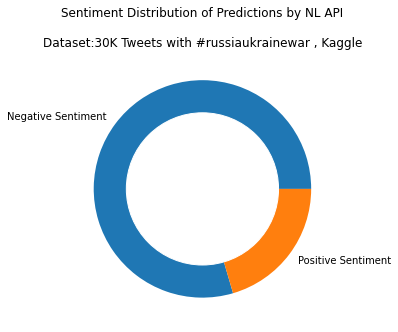

In [143]:
plt.figure(figsize=[6,5])
plt.pie([count_api[0],count_api[1]],labels=['Negative Sentiment','Positive Sentiment'])
cir=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(cir)
plt.title('Sentiment Distribution of Predictions by NL API\n \nDataset:30K Tweets with #russiaukrainewar , Kaggle')
plt.show()

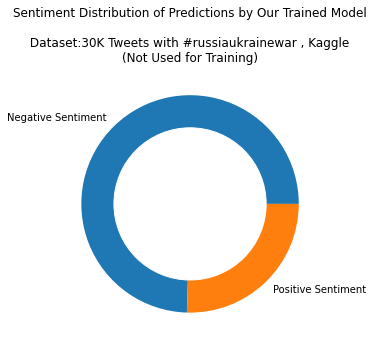

In [144]:
plt.figure(figsize=[6,5])
plt.pie([count_ens_model[0],count_ens_model[1]],labels=['Negative Sentiment','Positive Sentiment'])
cir=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(cir)
plt.title('Sentiment Distribution of' 
' Predictions by Our Trained Model\n'
' \n Dataset:30K Tweets with #russiaukrainewar , Kaggle \n'
'(Not Used for Training)')
plt.show()

Now, assuming that the predictions made by Natural Language API are true values or true labels, we shall calculate accuracy of our ensemble model as below,

Benchmarking with Natural Language API,

In [151]:
idx=(scores<-0.3 ) | (scores>0.3 ) 
# Ignoring the Neutral Tweets for comparison of Accuracy
# As our model predicts only positive or negative sentiments  
predict_api_wo_neutral=predictions_API[idx]
predict_model_wo_neutral=predict_ens[idx]
accuracy_score_benchmark=accuracy_score(predict_api_wo_neutral, predict_model_wo_neutral)
print(f'Accuracy with respect to Natural Language API is : {round(accuracy_score_benchmark*100,2)}%')

Accuracy with respect to Natural Language API is : 82.88%


Thus, we get about 83% match with Natural Language API on the '30K Tweets with russiaukrainewar hashtag' dataset from Kaggle which is not used anywhere in the model training.

**Observation and Discussion:** 

We can see that the majority of sentiments in the gathered data are negative. This suggests that people have a generally unfavorable view of the situation in Ukraine. In the context of the Russian invasion of Ukraine, this could mean that the actions of Russia and the impact of the conflict on the Ukrainian people have caused negative emotions and opinions towards the situation. 

On the other hand, the small percentage of positive sentiments could suggest that there are some positive developments or events related to the conflict that have been reported. For example, positive sentiments could be related to instances of aid or support for Ukraine or any developments that could lead to a peaceful resolution of the conflict. 

Overall, the fact that positive sentiments only account for 25% of the total sentiments suggests that not only people have a strongly negative perception of the situation in Ukraine but also Ukraine is not getting the proper attention, support, and aid needed.

**Please note that, until this point we have only trained and validated our model, analysis work is yet to be done using our trained model on Relatively Large Analysis Test Dataset from time period across the year 2022.**

# **Test data predictions**

In [ ]:
"""No need to execute the web scraping code, as the data has already been obtained and uploaded from a CSV file"""
"""Twitter data web scraping code"""
# !pip install snscrape
# import pandas as pd
# import snscrape.modules.twitter as sntwitter
# import datetime
# import timeit
# query = '#Ukrainewar OR #StandWithUkraine OR #StandWithRussia OR #standwithputin OR #UkraineRussiaWar OR #Nato OR #standwithzelensky OR #Ukraine OR #RussianAggression OR #UnitedForUkraine OR #Crimea OR #Donbass OR #WarInDonbass OR #IStandWithPutin OR #RussiaUkraineConflict'
# start_date = datetime.date(2022, 2, 20)
# end_date = datetime.date(2023, 3, 31)
# end_date-start_date

# start = timeit.default_timer()
# count = 0
# tweets = []
# delta = datetime.timedelta(days=1)
# for day in range((end_date - start_date).days + 1):
#     count+=1
#     print("Day: ", count)
#     tweets_day = []
#     since_date = (start_date + datetime.timedelta(days=day)).strftime('%Y-%m-%d')
#     until_date = (start_date + datetime.timedelta(days=day+1)).strftime('%Y-%m-%d')
#     query_day = f'{query} since:{since_date} until:{until_date}'
#     scraper = sntwitter.TwitterSearchScraper(query_day)
#     for i, tweet in enumerate(scraper.get_items()):
#         if i >= 1000:
#             break
#         data = [tweet.date, tweet.user.username, tweet.id, tweet.content, tweet.lang, tweet.user.location, tweet.coordinates, tweet.likeCount, tweet.retweetCount, tweet.hashtags, tweet.url]
#         tweets_day.append(data)
#     tweets.append(pd.DataFrame(tweets_day, columns=['Date', 'Username', 'Id', 'Text', 'Language', 'Location', 'Coordinates', 'Likes', 'Retweets', 'Hashtags', 'URL']))
#     clear_output(wait=True)


# df = pd.concat(tweets).reset_index(drop=True)

# stop = timeit.default_timer()
# print('Time: ', stop - start)

# df.to_csv('Twitter data ' + str(start_date) + ' to ' + str(end_date) + '.csv')

In [ ]:
'''Reading the twitter data'''
# twitter_data = pd.read_csv("Twitter data.csv") ### No need to run as we are directly uploading the text pre-processed csv file
# twitter_data

In [153]:
'''Function that performs the necessary text processing on a given dataframe'''
def text_preprocessing_tweet(df):
   ''' Input DataFrame is required to have a column named "Text" 
       on which all pre-processing will be done'''

   DF=df.copy(deep=True)
   DF['Tweet'] = df.loc[:, 'Text']


   # Changing to lowercase 
   DF['Text'] = DF['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

   # Removing special characters and words following @
   special_char=["rt","@\w*","http\S*","t.co\S*","[^a-zA-Z\s]","[^\w\s]"]
   for i in special_char:
     DF['Text'] = DF['Text'].str.replace(i,'')

   def language(sen):
     sen_t=sen.replace(' ','')
     if len(sen_t)>5:
       lang=detect_langs(sen)[0].lang
     else:
       lang='noten'
     return lang
  
   # Keeping examples only in English Language
   if ('Language' in (DF.columns)):
     idx=DF['Language']=='en'
     DF=DF[idx]  
   else:
     lang=DF['Text'].apply(lambda x:language(x))
     idx=lang=='en'
     DF=DF[idx]


   # Removing rows which have no non-whitespace characters   
   DF_T=DF.copy(deep=True)
   DF_T['Text'] = DF_T['Text'].str.replace(' ','')
   idx=(DF_T['Text'].apply(lambda x:len(x)))>0
   DF=DF[idx]

   # Removing rows which have no non-whitespace characters in the tweet column   
   DF_T=DF.copy(deep=True)
   DF_T['Tweet'] = DF_T['Tweet'].str.replace(' ','')
   idx=(DF_T['Tweet'].apply(lambda x:len(x)))>0
   DF=DF[idx]

   # Removing stopwords
   stop_words = stopwords.words('english')
   DF['Text'] = DF['Text'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))


   # Removing rare words
   words= pd.Series(' '.join(DF['Text']).split()).value_counts()
   idx=words==1
   rare_words=words[idx]
   DF['Text'] = DF['Text'].apply(lambda x: ' '.join(x for x in x.split() if x not in rare_words))

   # Performing Tokenization
   DF['Text'] = DF['Text'].apply(lambda x: word_tokenize(x))

   stemmer = PorterStemmer()
   def stemming(L):
     for i in range(0,len(L)):
      L[i]=stemmer.stem(L[i])
     return L

   # Performing Stemming
   DF['Text'] = DF['Text'].apply(lambda x: stemming(x))

   # Removing empty list
   DF = DF[DF['Text'] != '[]']

   return DF

In [154]:
"""No need to execute the text preprocessing code, as the text preprocessing has already been performed and uploaded from a CSV file"""
# Pre-processing the twitter data
# twitter_data = twitter_data.drop(['Index', 'Id'], axis = 1)
# df = text_preprocessing_tweet(twitter_data)
# df.to_csv('twitter_data_pre-processed.csv', sep=',', index=False)
# df

'No need to execute the text preprocessing code, as the text preprocessing has already been performed and uploaded from a CSV file'

In [185]:
# Reading the text preprocessed twitter data file
df = pd.read_csv('twitter_data_pre-processed.csv')

In [186]:
# Removes any rows where the 'Text' column contains an empty list
df = df[df['Text'] != '[]']
df

,Date,Username,Text,Language,Location,Coordinates,Likes,Retweets,Hashtags,URL,Tweet
0,2022-02-20 23:59:59+00:00,d801227313a94cc,"['bbc', 'news', 'ukrain', 'russia', 'possibl',...",en,NaN,NaN,1,0,"['Ukraine', 'Russia']",https://twitter.com/d801227313a94cc/status/149...,BBC News - #Ukraine: What are #Russia's possib...
1,2022-02-20 23:59:58+00:00,ttnewmm,"['nato', 'usa', 'uk', 'ukrain', 'usa', 'uk', '...",en,NaN,NaN,2,1,"['NATO', 'USA', 'UK', 'Ukraine']",https://twitter.com/ttnewmm/status/14955488150...,#NATO #USA #UK #Ukraine THE USA - UK - NATO NE...
2,2022-02-20 23:59:39+00:00,ban239,"['happi', 'paicip', 'mani', 'other', 'frigid',...",en,"Washington, DC, Kraków","Coordinates(longitude=-77.144435, latitude=38....",4,0,['StandWithUkraine'],https://twitter.com/ban239/status/149554873720...,Happy to have participated with so many others...
3,2022-02-20 23:59:29+00:00,JustAMazen,"['perhap', 'us', 'invad', 'canada', 'annex', '...",en,NaN,NaN,8,2,"['StandWithUkraine', 'PrayForUkraine']",https://twitter.com/JustAMazen/status/14955486...,"@OlgaNYC1211 Perhaps when US invades Canada, a..."
4,2022-02-20 23:59:17+00:00,em_az,"['yep', 'spanish', 'flu', 'call', 'told', 'put...",en,US,NaN,0,1,"['PutinsWar', 'UkraineRussiaCrisis', 'UkraineI...",https://twitter.com/em_az/status/1495548645889...,@mikecalma Yep. The Spanish flu called. Told P...
...,...,...,...,...,...,...,...,...,...,...,...
249123,2023-03-29 18:21:41+00:00,job360ng,"['current', 'hire', 'sma', 'passion', 'individ...",en,"Lagos, Nigeria",NaN,1,0,"['HIRINGNOW', 'lagosjobs', 'certificateofretur...",https://twitter.com/job360ng/status/1641143608...,We are currently hiring smart and passionate i...
249124,2023-03-29 18:21:39+00:00,lewski5800,"['trump', 'vladimir', 'putin', 'trump', 'putin...",en,NaN,NaN,0,0,"['trump', 'putin', 'ukraine', 'ninetyeight', '...",https://twitter.com/lewski5800/status/16411435...,Trump On Vladimir Putin 🤯 #trump #putin #ukrai...
249125,2023-03-29 18:21:30+00:00,f_o_r_Ukraine,"['happi', 'morn', 'russian', 'occupi', 'melito...",en,Ukraine,NaN,4,1,['UkraineWar'],https://twitter.com/f_o_r_Ukraine/status/16411...,Not very happy morning for Russians in occupie...
249126,2023-03-29 18:21:24+00:00,IvanIhorovych,"['break', 'ukrain', 'stori', 'deni', 'heard', ...",en,NaN,NaN,0,0,"['BREAKING', 'Ukraine', 'CrimesAgainstHumanity...",https://twitter.com/IvanIhorovych/status/16411...,"#BREAKING #Ukraine\nThe story of Denys, who he..."


In [187]:
# Checking null values
print(df.shape)
df['Text'].isna().value_counts()

(249115, 11)


False    249115
Name: Text, dtype: int64

In [188]:
# Transforming the 'Text' column
X_test_tweet = vectorizer.transform(df['Text'].astype(str))
X_test_tweet = X_test_tweet.toarray()
X_test_tweet = pd.DataFrame(data=X_test_tweet, columns=vectorizer.get_feature_names_out())

In [189]:
# Predicting the test data(twitter)
predict_ens_tweet = ens_sent_clf.predict(X_test_tweet)
predict_ens_tweet
# print(len(predict_ens_tweet))

array([0, 0, 0, ..., 1, 0, 1])

In [190]:
# Count of each prediction
count_ens_model_tweet=collections.Counter(predict_ens_tweet)
count_ens_model_tweet

Counter({0: 195180, 1: 53935})

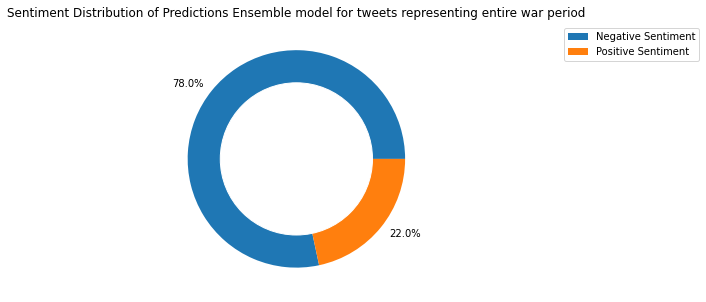

In [191]:
# Plotting the pie chart to visualize the sentiment analysis results of the test data 
plt.figure(figsize=[6,5])
total = total_1 = count_ens_model_tweet[0] + count_ens_model_tweet[1]
plt.pie([count_ens_model_tweet[0],count_ens_model_tweet[1]],labels=['{}%'.format(round(count_ens_model_tweet[0]/total_1, 2)*100),'{}%'.format(round(count_ens_model_tweet[1]/total, 2)*100)])
cir=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(cir)
plt.title('Sentiment Distribution of Predictions Ensemble model for tweets representing entire war period')
plt.legend(['Negative Sentiment', 'Positive Sentiment'], loc='upper right', bbox_to_anchor=(2, 1))
plt.show()

In [192]:
# Function that performs the necessary text processing for generating a wordcloud from tweets
def process_wordcloud_tweet(df):
  ''' Input DataFrame is required to have a column named "Tweet" 
      on which all pre-processing will be done'''

  DF=df.copy(deep=True)


  # Changing to lowercase 
  DF['Tweet_processed'] = DF['Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing special characters and words following @
  special_char=["rt","@\w*","http\S*","t.co\S*","[^a-zA-Z\s]","[^\w\s]"]
  for i in special_char:
    DF['Tweet_processed'] = DF['Tweet_processed'].str.replace(i,'')

  def language(sen):
    sen_t=sen.replace(' ','')
    if len(sen_t)>5:
      lang=detect_langs(sen)[0].lang
    else:
      lang='noten'
    return lang

  # Keeping examples only in English Language
  if ('Language' in (DF.columns)):
    idx=DF['Language']=='en'
    DF=DF[idx]  
  else:
    lang=DF['Tweet_processed'].apply(lambda x:language(x))
    idx=lang=='en'
    DF=DF[idx]

  DF=remove_gen_keywords(DF)

  # Removing rows which have no non-whitespace characters   
  DF_T=DF.copy(deep=True)
  DF_T['Tweet_processed'] = DF_T['Tweet_processed'].str.replace(' ','')
  idx=(DF_T['Tweet_processed'].apply(lambda x:len(x)))>0
  DF=DF[idx]

  # Removing stopwords
  stop_words = stopwords.words('english')
  DF['Tweet_processed'] = DF['Tweet_processed'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

  # Removing rare words
  words= pd.Series(' '.join(DF['Tweet_processed']).split()).value_counts()
  idx=words==1
  rare_words=words[idx]
  DF['Tweet_processed'] = DF['Tweet_processed'].apply(lambda x: ' '.join(x for x in x.split() if x not in rare_words))
 
  return DF

In [193]:
# Separating positive and negative tweets from the above dataset
idx_ukr=predict_ens_tweet==0
idx_rus=predict_ens_tweet==1
df_word_cloud_tweet=process_wordcloud_tweet(df)
df_ukr_tweet=(df_word_cloud_tweet[idx_ukr]).astype(str)
df_rus_tweet=(df_word_cloud_tweet[idx_rus]).astype(str)
df_neg = df[idx_ukr]
df_pos = df[idx_rus]

In [194]:
# Renaming and splitting the 'Date' column for performing further analysis in daraframe df_word_cloud_tweet
df_word_cloud_tweet.rename(columns={'Date': 'Datetime'}, inplace=True)
df_word_cloud_tweet['Date'] = df_word_cloud_tweet['Datetime'].str.split(' ')
df_word_cloud_tweet["Date"] = df_word_cloud_tweet["Date"].str[0]

In [195]:
# Preprocessing positive and negative tweet data and generating seperate word cloud for each category
a=df_ukr_tweet['Tweet_processed']
text_ukr_tweet=' '.join(a)
b=df_rus_tweet['Tweet_processed']
text_rus_tweet=' '.join(b)
word_cloud_ukr_tweet = WordCloud(collocations = False, background_color = 'white').generate(text_ukr_tweet)
word_cloud_rus_tweet = WordCloud(collocations = False, background_color = 'white').generate(text_rus_tweet)

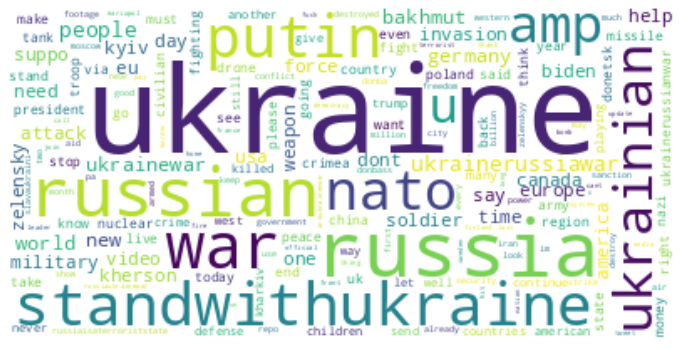

In [196]:
#Plotting WordCloud from Pro-Ukrainian Tweets (or Tweets with Negative Sentiment)
plt.figure(figsize=[12,10])
plt.imshow(word_cloud_ukr_tweet, interpolation='bilinear')
plt.axis("off")
plt.show()

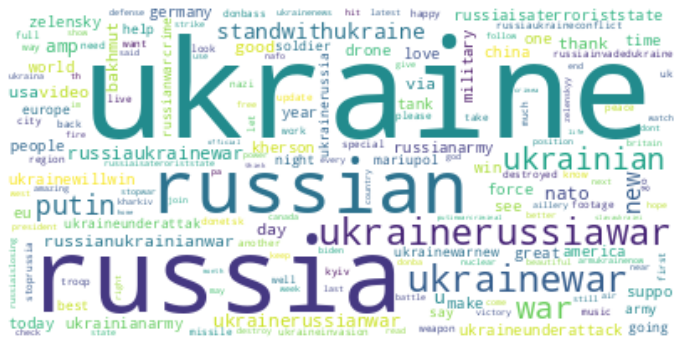

In [197]:
#Plotting WordCloud from Pro-Russian Tweets (or Tweets with Positive Sentiment)
plt.figure(figsize=[12,10])
plt.imshow(word_cloud_rus_tweet, interpolation='bilinear')
plt.axis("off")
plt.show()

In [180]:
df

,Datetime,Username,Text,Language,Location,Coordinates,Likes,Retweets,Hashtags,URL,Tweet,Datetime,prediction,positive_sentiment,negative_sentiment
0,2022-02-20 23:59:59+00:00,d801227313a94cc,"['bbc', 'news', 'ukrain', 'russia', 'possibl',...",en,NaN,NaN,1,0,"['Ukraine', 'Russia']",https://twitter.com/d801227313a94cc/status/149...,BBC News - #Ukraine: What are #Russia's possib...,2022-02-20,0,0,1
1,2022-02-20 23:59:58+00:00,ttnewmm,"['nato', 'usa', 'uk', 'ukrain', 'usa', 'uk', '...",en,NaN,NaN,2,1,"['NATO', 'USA', 'UK', 'Ukraine']",https://twitter.com/ttnewmm/status/14955488150...,#NATO #USA #UK #Ukraine THE USA - UK - NATO NE...,2022-02-20,0,0,1
2,2022-02-20 23:59:39+00:00,ban239,"['happi', 'paicip', 'mani', 'other', 'frigid',...",en,"Washington, DC, Kraków","Coordinates(longitude=-77.144435, latitude=38....",4,0,['StandWithUkraine'],https://twitter.com/ban239/status/149554873720...,Happy to have participated with so many others...,2022-02-20,0,0,1
3,2022-02-20 23:59:29+00:00,JustAMazen,"['perhap', 'us', 'invad', 'canada', 'annex', '...",en,NaN,NaN,8,2,"['StandWithUkraine', 'PrayForUkraine']",https://twitter.com/JustAMazen/status/14955486...,"@OlgaNYC1211 Perhaps when US invades Canada, a...",2022-02-20,0,0,1
4,2022-02-20 23:59:17+00:00,em_az,"['yep', 'spanish', 'flu', 'call', 'told', 'put...",en,US,NaN,0,1,"['PutinsWar', 'UkraineRussiaCrisis', 'UkraineI...",https://twitter.com/em_az/status/1495548645889...,@mikecalma Yep. The Spanish flu called. Told P...,2022-02-20,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249110,2023-03-29 18:21:41+00:00,job360ng,"['current', 'hire', 'sma', 'passion', 'individ...",en,"Lagos, Nigeria",NaN,1,0,"['HIRINGNOW', 'lagosjobs', 'certificateofretur...",https://twitter.com/job360ng/status/1641143608...,We are currently hiring smart and passionate i...,2023-03-29,1,1,0
249111,2023-03-29 18:21:39+00:00,lewski5800,"['trump', 'vladimir', 'putin', 'trump', 'putin...",en,NaN,NaN,0,0,"['trump', 'putin', 'ukraine', 'ninetyeight', '...",https://twitter.com/lewski5800/status/16411435...,Trump On Vladimir Putin 🤯 #trump #putin #ukrai...,2023-03-29,0,0,1
249112,2023-03-29 18:21:30+00:00,f_o_r_Ukraine,"['happi', 'morn', 'russian', 'occupi', 'melito...",en,Ukraine,NaN,4,1,['UkraineWar'],https://twitter.com/f_o_r_Ukraine/status/16411...,Not very happy morning for Russians in occupie...,2023-03-29,1,1,0
249113,2023-03-29 18:21:24+00:00,IvanIhorovych,"['break', 'ukrain', 'stori', 'deni', 'heard', ...",en,NaN,NaN,0,0,"['BREAKING', 'Ukraine', 'CrimesAgainstHumanity...",https://twitter.com/IvanIhorovych/status/16411...,"#BREAKING #Ukraine\nThe story of Denys, who he...",2023-03-29,0,0,1


In [198]:
# Renaming and splitting the 'Date' column for performing further analysis in dataframe df
df.rename(columns={'Date': 'Datetime'}, inplace=True)
df['Date'] = df['Datetime'].str.split(' ')
df["Date"] = df["Date"].str[0]

In [199]:
# Adding the 'prediction','positive_sentiment' and 'negative_sentiment' column to the dataframe df
df['prediction']= predict_ens_tweet
df['positive_sentiment'] = predict_ens_tweet
temp = predict_ens_tweet+1
df['negative_sentiment'] = temp
df.loc[(df.negative_sentiment == 2),'negative_sentiment']=0

In [200]:
# Getting the count of samples in each day
start_date = datetime.date(2022, 2, 20)
end_date = datetime.date(2023, 3, 29)
N = []
for delta in range((end_date - start_date).days + 1):
    day = start_date + datetime.timedelta(delta)
    N.append(df['Date'].value_counts()[str(day)])
# print(N)

In [201]:
# Sentiment analysis for each day
positive_sentiment = []
negative_sentiment = []
a = 0
n = 0
temp = []
for i in N:
    n = n+i
    temp.append(df[a:n].shape[0])
    day_predictions = df['prediction'][a:n]
    count_predictions = day_predictions.value_counts()
    negative_sentiment.append(count_predictions.get(0, 0))
    positive_sentiment.append(count_predictions.get(1, 0))
    a = n 

[509, 465, 554, 503, 494, 538, 510, 482, 513, 540, 534, 568, 565, 611, 563, 619, 571, 539, 551, 549, 538, 519, 530, 582, 563, 577, 563, 518, 526, 534, 518, 508, 556, 490, 518, 520, 541, 512, 581, 502, 536, 533, 564, 549, 517, 549, 551, 532, 548, 547, 534, 570, 492, 473, 511, 488, 492, 531, 565, 538, 544, 522, 543, 503, 559, 534, 532, 511, 527, 464, 515, 501, 518, 508, 444, 490, 497, 501, 519, 553, 525, 537, 537, 288, 537, 499, 493, 506, 503, 483, 508, 487, 541, 518, 575, 524, 499, 484, 453, 523, 464, 514, 476, 502, 527, 461, 516, 438, 506, 478, 497, 449, 503, 491, 523, 492, 511, 465, 449, 483, 515, 507, 495, 452, 444, 523, 476, 513, 429, 488, 458, 471, 458, 463, 476, 486, 501, 502, 468, 525, 477, 453, 443, 443, 457, 490, 478, 435, 484, 451, 491, 481, 431, 430, 430, 435, 451, 424, 475, 411, 486, 401, 455, 466, 522, 456, 471, 492, 437, 510, 492, 508, 480, 436, 436, 422, 438, 453, 471, 440, 412, 442, 463, 458, 428, 525, 454, 428, 424, 439, 402, 481, 435, 432, 430, 452, 478, 396, 439, 474,

In [202]:
# Calculating the percentage of sentiment in each category
neg_sentiment_arr = np.array(negative_sentiment)
pos_sentiment_arr = np.array(positive_sentiment)
total_neg_day = (neg_sentiment_arr/N)*100
total_pos_day = (pos_sentiment_arr/N)*100

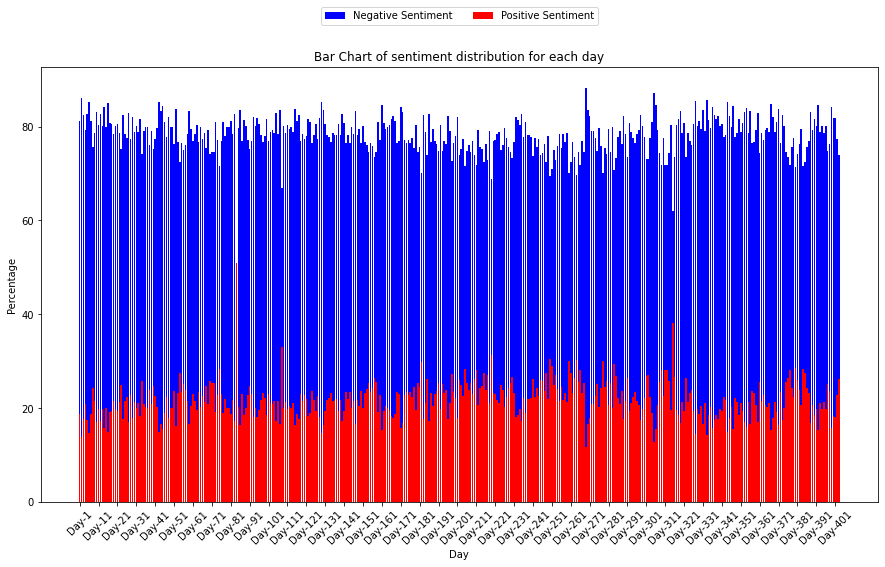

In [203]:
# Plotting the Sentiment analysis of each day
index = range(len(total_neg_day))
tick_labels = ['Day-' + str(i) for i in range(1, len(total_neg_day)+1, 10)]
plt.figure(figsize=(15,8))
plt.bar(index, total_neg_day, color='blue', label='Negative Sentiment')
plt.bar(index, total_pos_day, color='red', label='Positive Sentiment')
plt.xlabel('Day')
plt.ylabel('Percentage')
plt.title('Bar Chart of sentiment distribution for each day')
plt.xticks(range(0, len(total_neg_day), 10), tick_labels, rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

In [209]:
# Getting the count of samples in each week
week_n = []
a = math.floor(len(N)/7)
b = 0
for i in range(a):
  n = (i+1)*7
  week_n.append(sum(N[b:n]))
  b = n
c = len(N)%7
if c !=0:
  week_n.append(sum(N[-c:]))

In [211]:
# Sentiment analysis for each week
positive_sentiment_week = []
negative_sentiment_week = []
a = 0
n = 0
temp = []

for i in week_n:
    n = n + i
    temp.append(df[a:n].shape[0])
    week_predictions = df['prediction'][a:n]
    count_predictions = week_predictions.value_counts()
    negative_sentiment_week.append(count_predictions.get(0, 0))
    positive_sentiment_week.append(count_predictions.get(1, 0))
    a = n

In [212]:
# Calculating the percentage of sentiment in each category
neg_sentiment_arr = np.array(negative_sentiment_week)
pos_sentiment_arr = np.array(positive_sentiment_week)
total_neg_week = (neg_sentiment_arr/week_n)*100
total_pos_week = (pos_sentiment_arr/week_n)*100

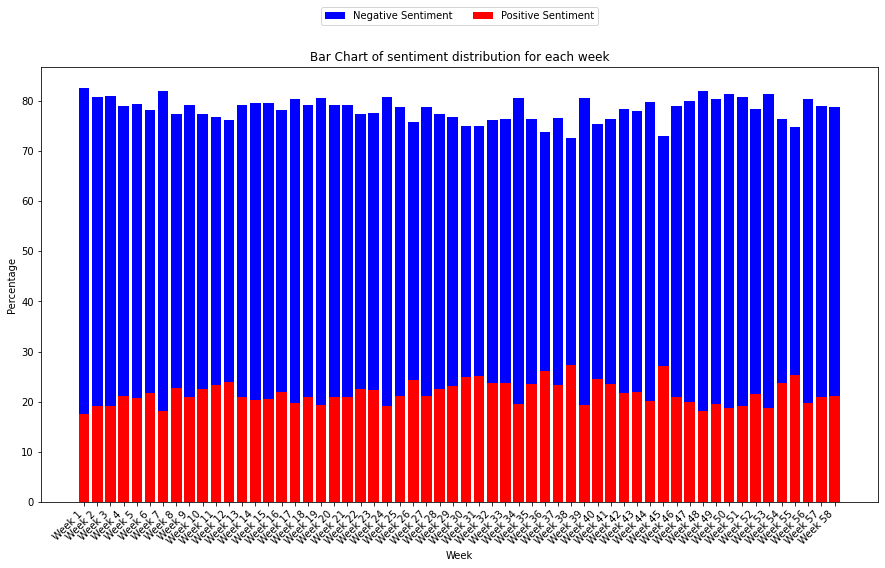

In [213]:
# Plotting the Sentiment analysis weekly
index = [f"Week {i+1}" for i in range(len(total_neg_week))]
plt.figure(figsize=(15,8))
plt.bar(index, total_neg_week, color='blue', label='Negative Sentiment')
plt.bar(index, total_pos_week, color='red', label='Positive Sentiment')
# x = np.arange(len(weeks))
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.xticks(index, rotation=45, ha='right')
plt.title('Bar Chart of sentiment distribution for each week')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

In [215]:
# Getting the count of samples in each month
df['Date'] = pd.to_datetime(df['Date'])
df['month_year'] = df['Date'].dt.to_period('M')
counts = df.groupby('month_year').size()
month_count = []
for month, count in counts.items():
    # print(f"{month.strftime('%B %Y')}: {count} days")
    month_count.append(count)

In [217]:
# Sentiment analysis for each month
positive_sentiment_month = []
negative_sentiment_month = []
a = 0
n = 0
temp = []

for i in month_count:
    n = n + i
    temp.append(df[a:n].shape[0])
    month_predictions = df['prediction'][a:n]
    count_predictions = month_predictions.value_counts()
    negative_sentiment_month.append(count_predictions.get(0, 0))
    positive_sentiment_month.append(count_predictions.get(1, 0))
    a = n
    

In [218]:
# Calculating the percentage of sentiment in each category
neg_sentiment_arr = np.array(negative_sentiment_month)
pos_sentiment_arr = np.array(positive_sentiment_month)
total_neg_month = (neg_sentiment_arr/month_count)*100
total_pos_month = (pos_sentiment_arr/month_count)*100

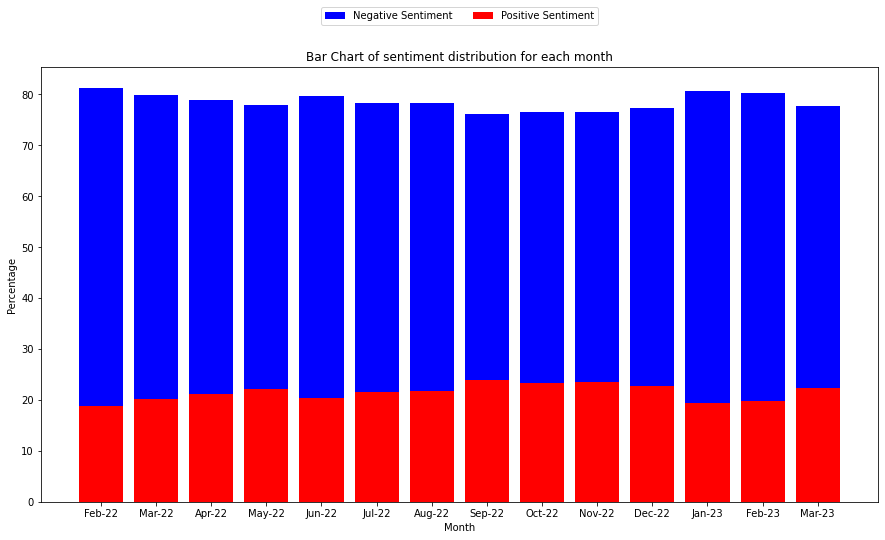

In [219]:
# Plotting the Sentiment analysis monthly
index = range(len(total_neg_month))
months = ['Feb-22', 'Mar-22', 'Apr-22', 'May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23']
plt.figure(figsize=(15,8))
plt.bar(index, total_neg_month, color='blue', label='Negative Sentiment')
plt.bar(index, total_pos_month, color='red', label='Positive Sentiment')
x = np.arange(len(months))
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(x, months)
plt.title('Bar Chart of sentiment distribution for each month')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

In [220]:
# Creating a dataframe for plotting the time series
index_value = [137.72, 154.50, 148.28, 151.17, 156.25, 156.70, 157.16, 161.71, 171.75, 168.53, 157.40, 158.32, 156.55, np.nan]
time_series_df = pd.DataFrame({'Date': months, 'Negative': total_neg_month, "Positive": total_pos_month, 'Macro data': index_value})
time_series_df

,Date,Negative,Positive,Macro data
0,Feb-22,81.281139,18.718861,137.72
1,Mar-22,79.813049,20.186951,154.50
2,Apr-22,78.884799,21.115201,148.28
3,May-22,77.950108,22.049892,151.17
4,Jun-22,79.647130,20.352870,156.25
5,Jul-22,78.360171,21.639829,156.70
6,Aug-22,78.233996,21.766004,157.16
7,Sep-22,76.018712,23.981288,161.71
8,Oct-22,76.588185,23.411815,171.75
9,Nov-22,76.434369,23.565631,168.53


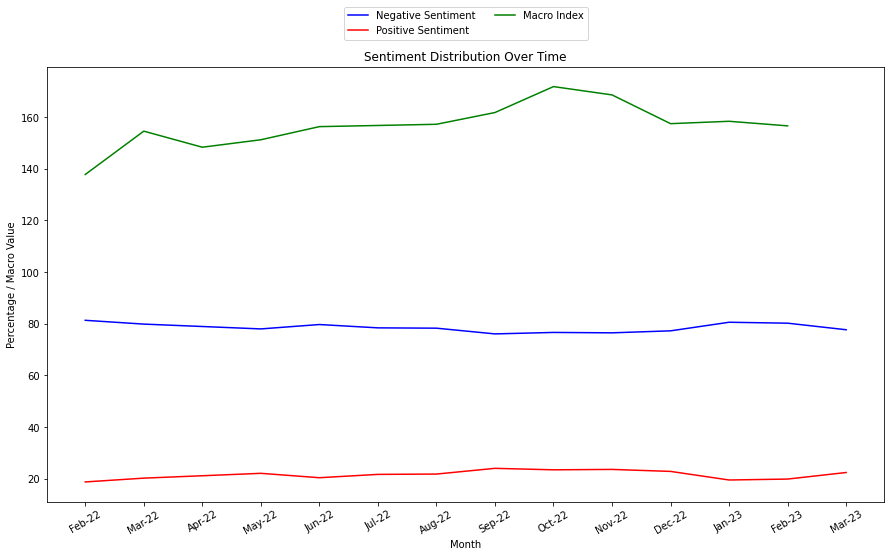

In [221]:
# Time-series plot of positive, negative and macro index
plt.figure(figsize=(15,8))
plt.plot(time_series_df['Date'], time_series_df['Negative'], color='blue', label='Negative Sentiment')
plt.plot(time_series_df['Date'], time_series_df['Positive'], color='red',label='Positive Sentiment')
plt.plot(time_series_df['Date'], time_series_df['Macro data'], color = 'green', label = 'Macro Index')

plt.xlabel('Month')
plt.ylabel('Percentage / Macro Value')
plt.title('Sentiment Distribution Over Time')
plt.xticks(rotation=30)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

In [223]:
# Calculating the percentage change of positive, negative and macro index
Percentage_Change = time_series_df[['Negative', 'Positive', 'Macro data']].pct_change()

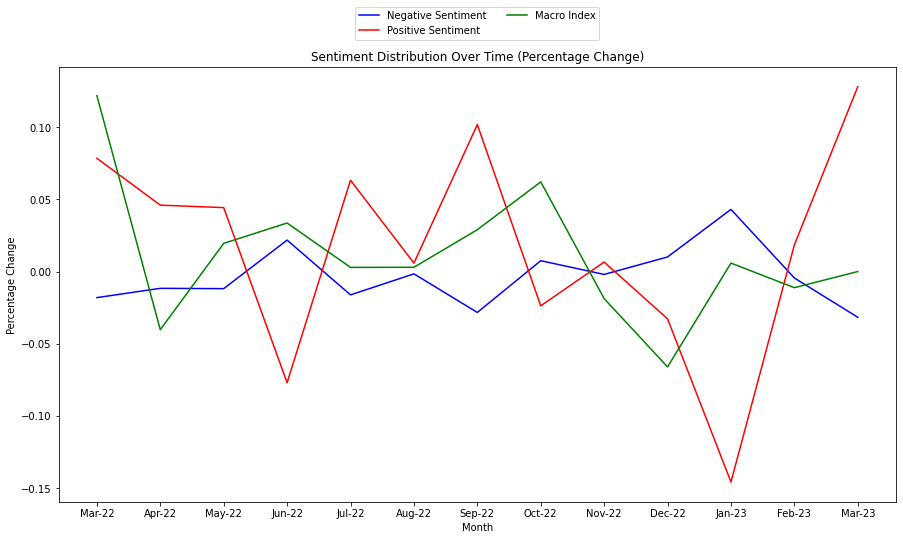

In [224]:
# Time-series plot of percentage change in positive, negative and macro index
plt.figure(figsize=(15, 8))
plt.plot(time_series_df['Date'], Percentage_Change['Negative'], color='blue', label='Negative Sentiment')
plt.plot(time_series_df['Date'], Percentage_Change['Positive'], color='red', label='Positive Sentiment')
plt.plot(time_series_df['Date'], Percentage_Change['Macro data'], color='green', label='Macro Index')
plt.xlabel('Month')
plt.ylabel('Percentage Change')
plt.title('Sentiment Distribution Over Time (Percentage Change)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

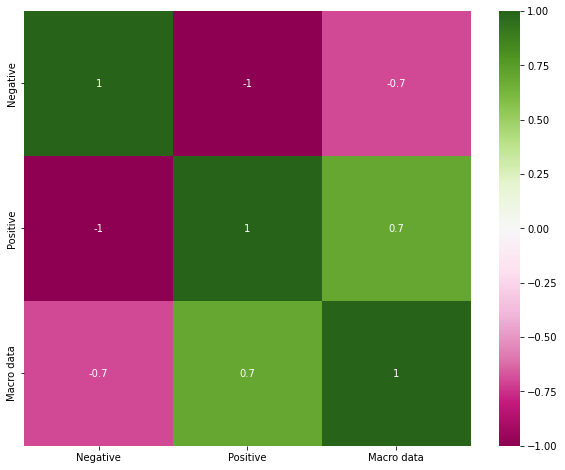

In [225]:
# Correlation plot for positive, negative and macro index
corr = time_series_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, vmin=-1, vmax=1, center= 0, cmap='PiYG', annot=True)
plt.show()

# **Factor and topics identification**

In [235]:
# LDA approach to perform topic modeling
def LDA(df):
    docs = [doc.split() for doc in df['Tweet_processed']]
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, random_state=42)
    topics = lda_model.show_topics(num_topics=20, num_words=10, formatted=False)
    topic_list = []
    for i, topic in topics:
        topic_words = [word for word, _ in topic]
        topic_array = np.array(topic_words)
        topic_list.append(topic_array)
    plot_terms = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return topic_list, plot_terms

In [338]:
# Negative twitter topics
twitter_neg_sentiment, plot_neg = LDA(df_ukr_tweet)
# twitter_neg_sentiment

In [237]:
# Terms in negative twitter topics
a = pd.concat({'Topics': pd.DataFrame(twitter_neg_sentiment)})
a

0                 1                  2  \
Topics 0                       war           ukraine               tank   
       1                   ukraine            russia                war   
       2                   ukraine                us          president   
       3                   bakhmut           ukraine            russian   
       4                      nato                eu                usa   
       5                   germany            canada            america   
       6                   ukraine               win          terrorist   
       7                     china           ukraine               nato   
       8                   ukraine            poland              group   
       9                   ukraine           destroy            germany   
       10         standwithukraine    ukrainewillwin               help   
       11                 soldiers           ukraine               kyiv   
       12                  ukraine                 c             months   
       13                  ukraine          children             people   
       14  russiaisaterroriststate  standwithukraine            leopard   
       15                  ukraine             putin              money   
       16                  ukraine            russia              putin   
       17                  ukraine               amp           invasion   
       18                  ukraine              kyiv             russia   
       19                   wagner           ukraine  ukrainerussianwar   

                   3                 4                 5                    6  \
Topics 0      russia               amp            crimes           ukrainewar   
       1      people              like              dont                world   
       2      battle           freedom         democracy              britain   
       3   ukrainian            attack            forces              footage   
       4     ukraine            russia               amp                   us   
       5     ukraine             biden          horrible               russia   
       6     victory          minister               cnn             together   
       7      brutal            russia                us               sweden   
       8      combat             march              repo                  aid   
       9     nuclear             front             bombs                armed   
       10      video              free             putin               family   
       11    russian         ukrainian           germany               killed   
       12      truth            todays             stand                 evil   
       13        war               one             syria               russia   
       14     strike           ukraine             gopro  putinisawarcriminal   
       15        mar  ukrainerussiawar             nazis                 send   
       16        war               amp            crimea           ammunition   
       17    russias            russia               map                 iran   
       18      tanks            drones            troops              russian   
       19  destroyed        ukrainewar  ukrainerussiawar              soledar   

                    7              8          9  
Topics 0        media     propaganda  continues  
       1          amp          putin       want  
       2       united      zelenskyy     states  
       3      donetsk          drone    kherson  
       4       europe      countries     turkey  
       5          war            usa      trump  
       6        state        foreign       high  
       7      finland             ua       join  
       8    including          glory       fire  
       9       russia         france         th  
       10        stay       hundreds    hungary  
       11      troops        special       kiev  
       12         min      australia     taking  
       13        lost  armukrainenow      years  
     

In [238]:
# Relevant terms for the negative sentiment topic
pyLDAvis.display(plot_neg)

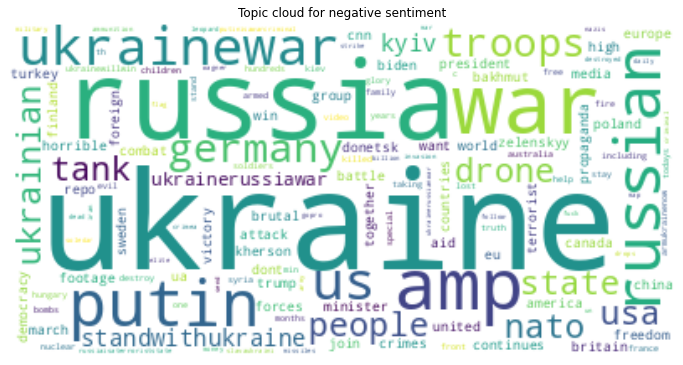

In [239]:
# Topic cloud for negative sentiment
topic_text_combined = ' '.join([' '.join(topic_words) for topic_words in twitter_neg_sentiment])
wordcloud = WordCloud(background_color='white').generate(topic_text_combined)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic cloud for negative sentiment")
plt.show()

In [339]:
# Positive twitter topics
twitter_pos_sentiment, plot_pos = LDA(df_rus_tweet)
# twitter_pos_sentiment

In [241]:
# Terms in positive twitter topics
b = pd.concat({'Topics': pd.DataFrame(twitter_pos_sentiment)})
b

0                 1            2                    3  \
Topics 0   ukraine            russia          usa                 nato   
       1   ukraine           bakhmut       russia           ukrainewar   
       2   ukraine            russia       wagner              kherson   
       3   ukraine           germany         good               russia   
       4   ukraine              nafo       russia              special   
       5   ukraine            russia          war              russian   
       6   ukraine           russian       russia     ukrainerussiawar   
       7   ukraine             nazis         well                 nazi   
       8     video           ukraine       please  zelenskywarcriminal   
       9   ukraine            russia        putin     ukrainerussiawar   
       10  ukraine    ukrainewillwin        suppo     ukrainerussiawar   
       11  america           ukraine      weapons                   vs   
       12  ukraine  ukrainerussiawar   ukrainewar                  war   
       13   canada           ukraine      germany              america   
       14  ukraine           britain       russia                  god   
       15  ukraine            russia         free                  war   
       16  ukraine               get         much                 make   
       17  ukraine  standwithukraine         love                 good   
       18  ukraine             happy         full                front   
       19  ukraine              like  ukrainenews               recipe   

                                 4                 5                 6  \
Topics 0                     china               war                us   
       1                   russian  ukrainerussiawar         ukrainian   
       2                   russian             today                th   
       3                   leopard         equipment              link   
       4                       top         operation      warinukraine   
       5                    donbas              news           russias   
       6                     drone         ukrainian           footage   
       7                      life       naziukraine            winter   
       8                     check             nowar  ukrainewarvideos   
       9   russiaisaterroriststate        ukrainewar               war   
       10                   thanks              year               war   
       11                   russia           soldier                 z   
       12                   russia    ukrainewarnews               new   
       13                   russia              tank           aillery   
       14                  victory              iran               new   
       15                    fight               via              team   
       16                   russia            resist                im   
       17                    thank   standwithrussia             music   
       18                      day             visit        ukrainewar   
       19                    looks       slavaukrani               afu   

                            7                       8                 9  
Topics 0                   eu                     amp                uk  
       1    ukrainerussianwar                     war  russiaukrainewar  
       2                  day                fighters             black  
       3                  via                      eu             india  
       4               united           europeanunion               war  
       5           ukrainewar        ukrainerussiawar             putin  
       6           ukrainewar                  forces           donetsk  
       7              winning        ukrainerussiawar         ukrainian  
       8              ukraina                  tiktok                th  
       9              russian  russiaisateroriststate  russianwarcrimes  
       10          ukrainewar                   great            drones  
       11          

In [242]:
# Relevant terms for the positive sentiment topic
pyLDAvis.display(plot_pos)

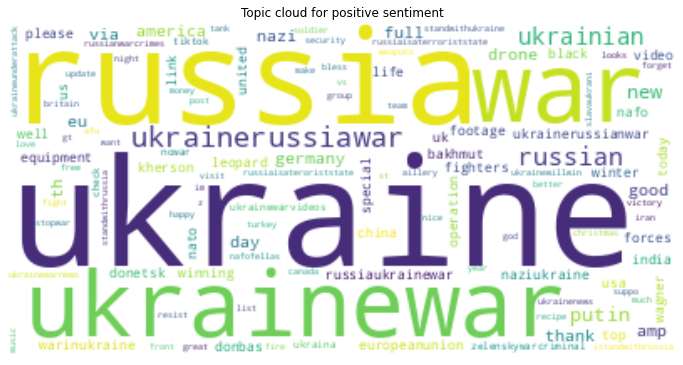

In [243]:
# Topic cloud for positive sentiment
topic_text_combined = ' '.join([' '.join(topic_words) for topic_words in twitter_pos_sentiment])
wordcloud = WordCloud(background_color='white').generate(topic_text_combined)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Topic cloud for positive sentiment")
plt.show()

In [244]:
# Random 50 sample for negative sentiment
df_neg_tweet=pd.DataFrame(np.random.permutation(df[idx_ukr]),columns=df.columns)

df_neg_sample=df_neg_tweet.iloc[0:50,:]
df_neg_sample.to_csv('twitter_negative_sample.csv', sep=',', index=False)
df_neg_sample

,Datetime,Username,Text,Language,Location,Coordinates,Likes,Retweets,Hashtags,URL,Tweet,Date,prediction,positive_sentiment,negative_sentiment,month_year
0,2022-10-26 22:29:40+00:00,OneVenusThrow,"['kill', 'everyonerussian', 'violenc', 'ukrain...",en,Manna-hata,NaN,0,1,"['Ukraine', 'brutality', 'WarCrimes', 'Russia']",https://twitter.com/OneVenusThrow/status/15853...,'Kill everyone':Russian violence in #Ukraine w...,2022-10-26,0,0,1,2022-10
1,2022-08-05 22:35:18+00:00,SanctionsAml,"['biden', 'elect', 'trump', 'foreign', 'polici...",en,NaN,NaN,1,1,"['Biden', 'Trump', 'Taliban', 'Iran', 'Putin',...",https://twitter.com/SanctionsAml/status/155568...,"#Biden - elected for ""not being #Trump"". But h...",2022-08-05,0,0,1,2022-08
2,2022-07-18 23:29:53+00:00,theghostgiver,"['usip', 'vladimir', 'putin', 'may', 'limit', ...",en,"California, USA",NaN,0,0,['Ukraine'],https://twitter.com/theghostgiver/status/15491...,USIP: While Vladimir Putin may have limited hi...,2022-07-18,0,0,1,2022-07
3,2023-01-29 23:20:48+00:00,Hi45733134,"['gopro', 'footag', 'ukrain', 'brutal', 'attac...",en,NaN,NaN,0,0,"['Canada', 'Germany', 'America', 'Ukraine', 'B...",https://twitter.com/Hi45733134/status/16198379...,GoPro footage! Ukraine's Brutal Attack on Luha...,2023-01-29,0,0,1,2023-01
4,2023-03-29 19:28:47+00:00,RabiaSalem02,"['horribl', 'headcam', 'ukrain', 'war', 'video...",en,Libya,NaN,0,0,"['Canada', 'Germany', 'America', 'Ukraine', 'B...",https://twitter.com/RabiaSalem02/status/164116...,"Horrible head-cam, Ukraine war video footage, ...",2023-03-29,0,0,1,2023-03
5,2022-04-21 23:48:35+00:00,sgervay,"['eah', 'day', 'day', 'rememb', 'act', 'save',...",en,Sydney,NaN,1,0,['standwithukraine'],https://twitter.com/sgervay/status/15172892228...,Earth day is the day we remember to act to sav...,2022-04-21,0,0,1,2022-04
6,2022-05-11 23:56:46+00:00,MimiTexasAngel,"['cannabi', 'replac', 'fossil', 'fuel', 'eat',...",en,Planet Earth,NaN,0,0,"['Cannabis', 'Ukraine']",https://twitter.com/MimiTexasAngel/status/1524...,@SenSherrodBrown @GrandmaShark18 #Cannabis can...,2022-05-11,0,0,1,2022-05
7,2022-02-21 23:56:17+00:00,MateuszSobiera3,"['barack', 'obama', 'sinc', 'main', 'threat', ...",en,NaN,NaN,0,0,"['BreakingNews', 'Russia', 'Ukraine', 'Poland'...",https://twitter.com/MateuszSobiera3/status/149...,Barack Obama: 'Since the 1980s the main threat...,2022-02-21,0,0,1,2022-02
8,2022-06-17 23:01:38+00:00,art24karat,"['agre', 'made', 'mess', 'whole', 'world', 'po...",en,"Hopkinton, MA",NaN,0,0,"['Ukraine', 'Russia']",https://twitter.com/art24karat/status/15379335...,@rishibagree I agree he has made a mess in the...,2022-06-17,0,0,1,2022-06
9,2022-04-05 23:57:55+00:00,hamidashraf1,"['your', 'democrat', 'ukrain', 'dare', 'critic...",en,Iran,NaN,0,0,"['ukraine', 'torture']",https://twitter.com/hamidashraf1/status/151149...,"@Soheil34874913 If you're in ""democratic"" #ukr...",2022-04-05,0,0,1,2022-04


In [245]:
# Random 50 sample for positive sentiment
df_pos_tweet=pd.DataFrame(np.random.permutation(df[idx_rus]),columns=df.columns)

df_pos_sample=df_pos_tweet.iloc[0:50,:]
df_pos_sample.to_csv('twitter_positive_sample.csv', sep=',', index=False)
df_pos_sample

,Datetime,Username,Text,Language,Location,...,Date,prediction,positive_sentiment,negative_sentiment,month_year
0,2022-05-31 22:46:00+00:00,JFK_ALlivestill,"['bunch', 'rot', 'real', 'truth', 'unlik', 'uk...",en,"Atlanta, GA, USA",...,2022-05-31,1,1,0,2022-05
1,2022-09-20 23:27:01+00:00,knittingknots,"['thread', 'ukrain', 'ukrainerussiawar', 'ukra...",en,in the Minnesota North Woods,...,2022-09-20,1,1,0,2022-09
2,2022-11-13 23:49:35+00:00,AlexMalejewicz,"['theyr', 'call', 'ukrainian', 'havent', 'got'...",en,新潟市日本,...,2022-11-13,1,1,0,2022-11
3,2023-01-22 22:47:23+00:00,TruthPuke,"['armedforc', 'ukrain', 'conceal', 'tank', 'ar...",en,"Calabasas, CA",...,2023-01-22,1,1,0,2023-01
4,2022-12-28 22:17:26+00:00,ReportWar1,"['new', 'footag', 'kharkov', 'explos', 'facil'...",en,NaN,...,2022-12-28,1,1,0,2022-12
5,2022-11-14 22:40:00+00:00,24talker,"['cia', 'director', 'meet', 'russian', 'counte...",en,United States,...,2022-11-14,1,1,0,2022-11
6,2022-10-21 22:01:57+00:00,DesignMobyy,"['stand', 'ukrain', 'tshi', 'link', 'kiev', 'u...",en,NaN,...,2022-10-21,1,1,0,2022-10
7,2022-03-04 23:56:03+00:00,OneVenusThrow,"['latest', 'there', 'standoff', 'ukrainian', '...",en,Manna-hata,...,2022-03-04,1,1,0,2022-03
8,2023-02-28 23:35:01+00:00,david_n919,"['battl', 'bakhmut', 'war', 'germani', 'ukrain...",en,NaN,...,2023-02-28,1,1,0,2023-02
9,2022-05-23 22:49:54+00:00,katusha4145,"['ukrainian', 'want', 'pa', 'russia', 'bbc', '...",en,Behind the enemy lines.,...,2022-05-23,1,1,0,2022-05


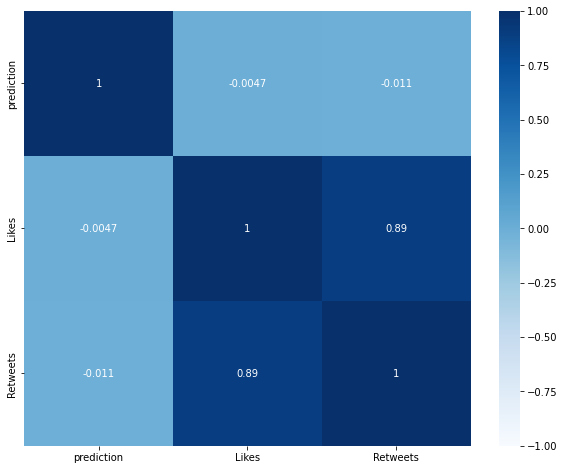

In [246]:
# Correlation of likes and retweets with prediction
correlation = df[['prediction', 'Likes', 'Retweets']].corr()
correlation
plt.figure(figsize=(10,8))
sns.heatmap(correlation, vmin=-1, vmax=1, center= 0, cmap=sns.color_palette("Blues", as_cmap=True), annot=True)
plt.show()

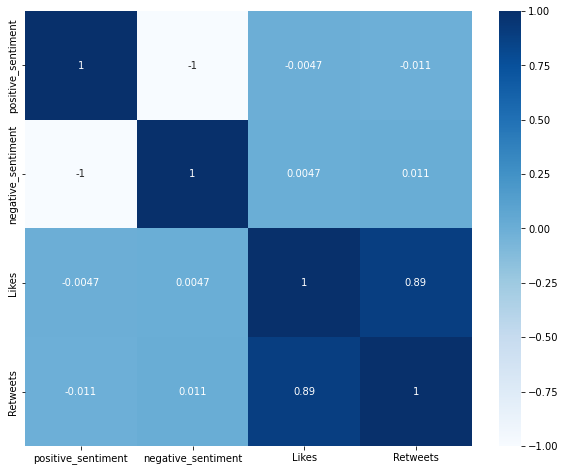

In [247]:
# Correlation of likes and retweets with positive and negative sentiment
correlation = df[['positive_sentiment', 'negative_sentiment', 'Likes', 'Retweets']].corr()
correlation
plt.figure(figsize=(10,8))
sns.heatmap(correlation, vmin=-1, vmax=1, center= 0, cmap=sns.color_palette("Blues", as_cmap=True), annot=True)
plt.show()

# **Sentiment analysis for specific dates (and one day after) with respect to the important events of the war**

In [294]:
# Function that gets the count of each prediction for a single day
def sentiment_analysis(day, df):
  n = df['Date'].value_counts()[str(day)]
  df['Date'] = pd.to_datetime(df['Date'])
  date = pd.to_datetime(str(day))
  df_day = df[df['Date'] == date]
  count_ens_model_day = collections.Counter(df_day['prediction'])
  return count_ens_model_day

In [295]:
# Function that plots pie chart of sentiment analysis for three days (previous, current, and next day) 
def pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, a, b, c):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
  ax1 = axes[0]
  ax2 = axes[1]
  ax3 = axes[2]  

  total_1 = count_ens_model_prev_day[0] + count_ens_model_prev_day[1]
  total_2 = count_ens_model_day[0] + count_ens_model_day[1]
  total_3 = count_ens_model_next_day[0] + count_ens_model_next_day[1]

  ax1.pie([count_ens_model_prev_day[0],count_ens_model_prev_day[1]],labels=['{:.2f}%'.format(count_ens_model_prev_day[0]/total_1*100),'{:.2f}%'.format(count_ens_model_prev_day[1]/total_1*100)])
  ax2.pie([count_ens_model_day[0],count_ens_model_day[1]],labels=['{:.2f}%'.format(count_ens_model_day[0]/total_2*100),'{:.2f}%'.format(count_ens_model_day[1]/total_2*100)])
  ax3.pie([count_ens_model_next_day[0],count_ens_model_next_day[1]],labels=['{:.2f}%'.format(count_ens_model_next_day[0]/total_3*100),'{:.2f}%'.format(count_ens_model_next_day[1]/total_3*100)])

  circle_1 = plt.Circle((0, 0), 0.7, color='white')
  circle_2 = plt.Circle((0, 0), 0.7, color='white')
  circle_3 = plt.Circle((0, 0), 0.7, color='white')
  axes[0].add_artist(circle_1)
  axes[1].add_artist(circle_2)
  axes[2].add_artist(circle_3)

  axes[0].set_title('{}'.format(a))
  axes[1].set_title('{}'.format(b))
  axes[2].set_title('{}'.format(c))

  fig.suptitle('Sentiment analysis for Previous, Current, and Next Day', fontsize=14, y=0.75, fontweight='bold')

  ax3.legend(['Negative Sentiment', 'Positive Sentiment'], loc='upper right', bbox_to_anchor=(2, 1))
  plt.show()

In [296]:
# This function performs topic modelling using LDA on the given dataframe df
def LDA_Event(df, n):   # n is the number of topics 
    docs = [doc.split() for doc in df['Tweet_processed']]
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n, random_state=42)
    topics = lda_model.show_topics(num_topics=n, num_words=10, formatted=False)
    topic_list = []
    for i, topic in topics:
        topic_words = [word for word, _ in topic]
        topic_array = np.array(topic_words)
        topic_list.append(topic_array)
    plot_terms = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return topic_list, plot_terms

**March 9th, 2022 - Mariupol maternity hospital attack**<br>

In [299]:
# March 8th, 9th and 10th
prev_day = datetime.date(2022, 3, 8)
day = datetime.date(2022, 3, 9)
next_day = datetime.date(2022, 3, 10)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

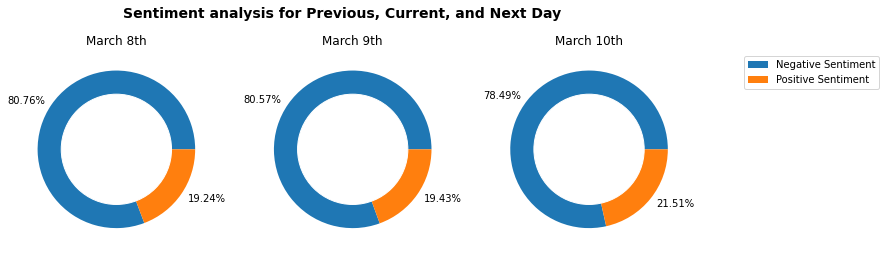

In [298]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'March 8th', 'March 9th', 'March 10th')

In [301]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**April 8th, 2022 - Missile strike on railway station**<br>

In [303]:
# April 7th, 8th and 9th
prev_day = datetime.date(2022, 4, 7)
day = datetime.date(2022, 4, 8)
next_day = datetime.date(2022, 4, 9)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

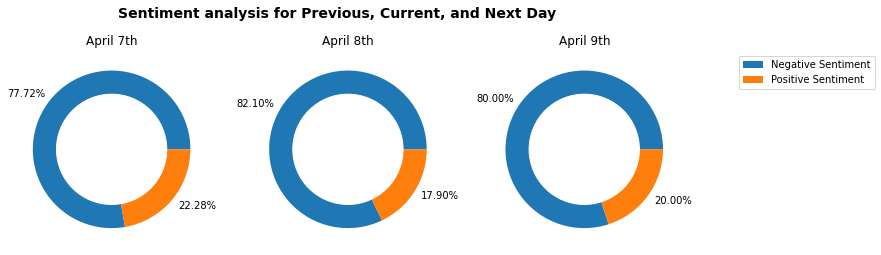

In [255]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'April 7th', 'April 8th', 'April 9th')

In [305]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**May 17th, 2022 - Mariupol defenders surrender to Russia**<br>

In [307]:
# May 16th, 17th and 18th
prev_day = datetime.date(2022, 5, 16)
day = datetime.date(2022, 5, 17)
next_day = datetime.date(2022, 5, 18)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

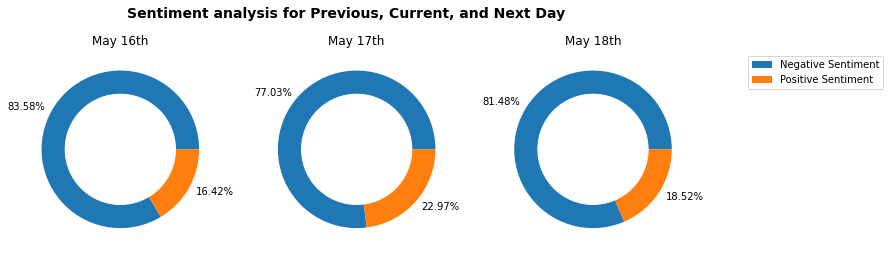

In [258]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'May 16th', 'May 17th', 'May 18th')

In [309]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**June 30th, 2022 - Ukraine fetes Russian pullback from strategic Snake Island outpost**<br>

In [310]:
# June 29th, 30th and July 1st
prev_day = datetime.date(2022, 6, 29)
day = datetime.date(2022, 6, 30)
next_day = datetime.date(2022, 7, 1)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

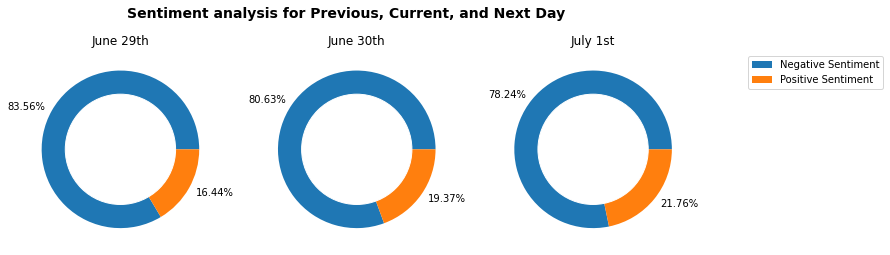

In [261]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'June 29th', 'June 30th', 'July 1st')

In [312]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**July 3rd, 2022 - Last major Ukraine-controlled city in Luhansk region falls to Russia**<br>

In [313]:
# July 2nd, 3rd and 4th
prev_day = datetime.date(2022, 7, 2)
day = datetime.date(2022, 7, 3)
next_day = datetime.date(2022, 7, 4)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

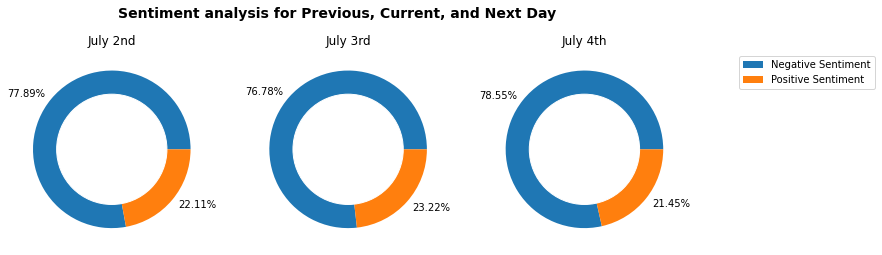

In [264]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'July 2nd', 'July 3rd', 'July 4th')

In [315]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**September 12th, 2022 - Ukraine reclaims more territory, reports capturing many POWs**<br>

In [316]:
# September 11th, 12th and 13th
prev_day = datetime.date(2022, 9, 11)
day = datetime.date(2022, 9, 12)
next_day = datetime.date(2022, 9, 13)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

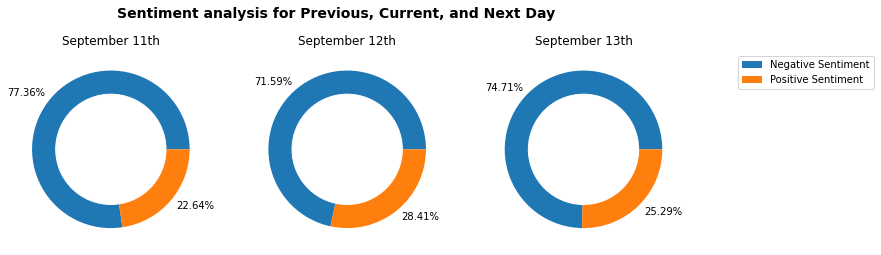

In [267]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'September 11th', 'September 12th', 'September 13th')

In [318]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**October 10th, 2022 - Russia rained cruise missiles on busy Ukrainian cities**<br>

In [319]:
# October 9th, 10th and 11th
prev_day = datetime.date(2022, 10, 9)
day = datetime.date(2022, 10, 10)
next_day = datetime.date(2022, 10, 11)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

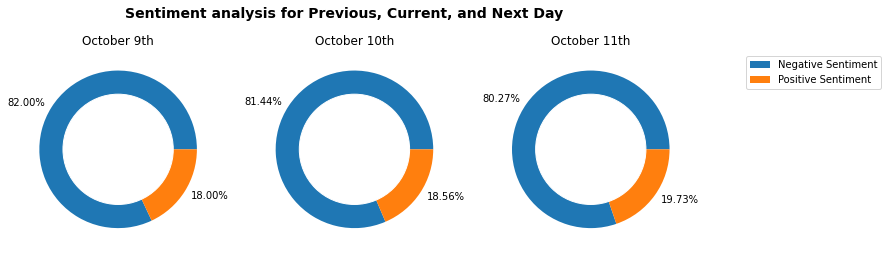

In [270]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'October 9th', 'October 10th', 'October 11th')

In [321]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**November 9th, 2022 - Russia says it's withdrawing from the key city of Kherson, but Ukraine is skeptical**<br>

In [322]:
# November 8th, 9th and 10th
prev_day = datetime.date(2022, 11, 8)
day = datetime.date(2022, 11, 9)
next_day = datetime.date(2022, 11, 10)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

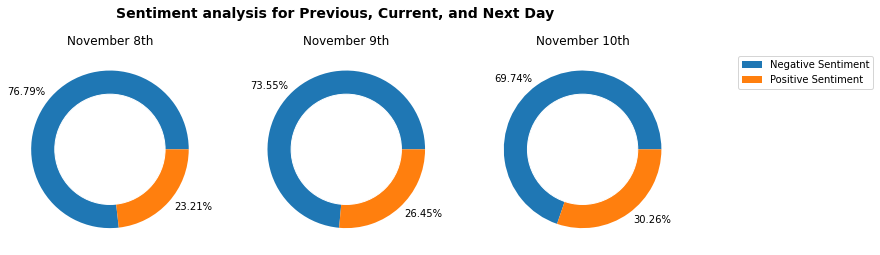

In [273]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'November 8th', 'November 9th', 'November 10th')

In [324]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**December 6th, 2022 - Ukraine strikes another Russian air base**<br>

In [325]:
# December 5th, 6th and 7th
prev_day = datetime.date(2022, 12, 5)
day = datetime.date(2022, 12, 6)
next_day = datetime.date(2022, 12, 7)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

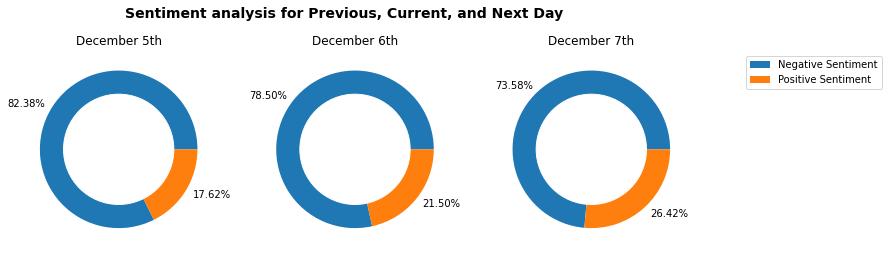

In [276]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'December 5th', 'December 6th', 'December 7th')

In [327]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**January 4th, 2023 - Russian military under scrutiny after 89 soldiers were killed in single Ukraine artillery attack**<br>

In [328]:
# January 3rd, 4th and 5th
prev_day = datetime.date(2023, 1, 3)
day = datetime.date(2023, 1, 4)
next_day = datetime.date(2023, 1, 5)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

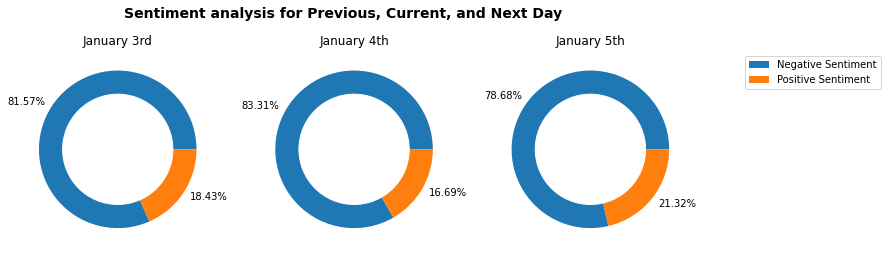

In [279]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'January 3rd', 'January 4th', 'January 5th')

In [330]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**February 8th, 2023 - Zelenskiy Appeals for Fighter Jets**<br>

In [332]:
# February 7th, 8th and 9th
prev_day = datetime.date(2023, 2, 7)
day = datetime.date(2023, 2, 8)
next_day = datetime.date(2023, 2, 9)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

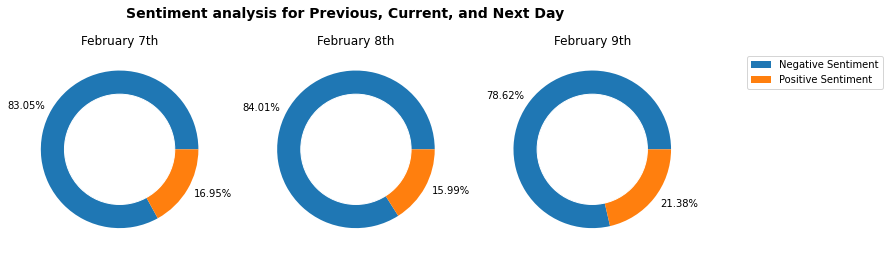

In [282]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'February 7th', 'February 8th', 'February 9th')

In [334]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

**March 7th, 2023 - The video of Ukrainian Soldier getting executed**<br>

In [335]:
# March 6th, 7th and 8th
prev_day = datetime.date(2023, 3, 6)
day = datetime.date(2023, 3, 7)
next_day = datetime.date(2023, 3, 8)
count_ens_model_prev_day = sentiment_analysis(prev_day, df)
count_ens_model_day = sentiment_analysis(day, df)
count_ens_model_next_day = sentiment_analysis(next_day, df)

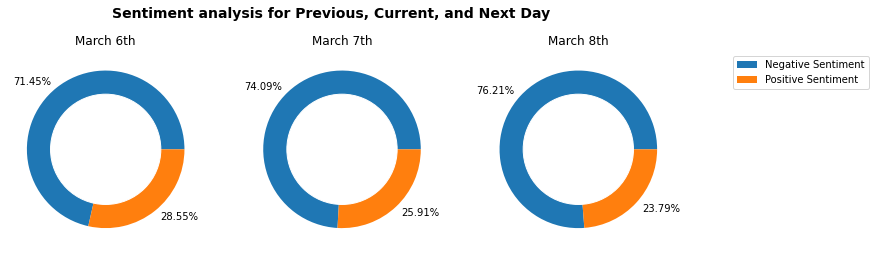

In [285]:
# Plotting the pie chat
pie_plot(count_ens_model_prev_day, count_ens_model_day, count_ens_model_next_day, 'March 6th', 'March 7th', 'March 8th')

In [337]:
# Relevant terms
date = next_day.strftime('%Y-%m-%d')
twitter_sentiment_event, plot_event = LDA_Event(df_word_cloud_tweet.loc[df_word_cloud_tweet['Date'] == date], 10)
pyLDAvis.display(plot_event)

In [287]:
# code to find the longtitude and latitude of locations and use in Tableau
# df_topic_neg["Location"] = df_topic_neg["Location"].astype(str)
# df_topic_pos["Location"] = df_topic_pos["Location"].astype(str)
#location_negative = df_topic_neg["Location"].str.cat(sep=' ')
#location_positive = df_topic_pos["Location"].str.cat(sep=' ')
#import spacy
#nlp = spacy.load('en_core_web_sm')
#doc_neg = nlp(location_negative)
#doc_pos = nlp(location_positive)
# Extract the named entities and create a list of tuples
#entities_neg = [(ent.text, ent.label_) for ent in doc_neg.ents]
#entities_pos = [(ent.text, ent.label_) for ent in doc_pos.ents]
# Create a Pandas DataFrame from the list of tuples
#df1_negative = pd.DataFrame(entities_neg, columns=['entity_text', 'entity_label'])
#df1_positive = pd.DataFrame(entities_pos, columns=['entity_text', 'entity_label'])
#df1_negative["entity_label"].value_counts()
#df1_positive["entity_label"].value_counts()
#df1_negative = df1_negative[(df1_negative["entity_label"] == "GPE") | (df1_negative["entity_label"] == "LOC")]
#df1_positive = df1_positive[(df1_positive["entity_label"] == "GPE") | (df1_positive["entity_label"] == "LOC")]
#location = df1_negative["entity_text"]
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="my-app")
#results = []
#for loc in location:
    #location = geolocator.geocode(loc)
    #if location is not None:
        #results.append(( location.latitude, location.longitude))
    #else:
        #results.append(( None, None))
#df_neg = pd.DataFrame(results, columns=['latitude','longitude'])
#location = df1_positive["entity_text"]
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="my-app")
#results = []
#for loc in location:
    #location = geolocator.geocode(loc)
    #if location is not None:
        #results.append(( location.latitude, location.longitude))
    #else:
        #results.append(( None, None))
#df_pos = pd.DataFrame(results, columns=['latitude','longitude'])